## Célula 1: Configuração e Bibliotecas
Importação das bibliotecas essenciais (PyTorch, Pandas, Scikit-learn) e configuração de sementes (seed) para garantir a reprodutibilidade dos resultados. Também defino os caminhos dos datasets e verifico a disponibilidade da GPU (CUDA) para acelerar o processamento.

In [ ]:
import os
import random
from pathlib import Path
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, Dataset
import torchvision
from torchvision import transforms, models, datasets

from sklearn.metrics import (accuracy_score, precision_recall_fscore_support,
                             multilabel_confusion_matrix, classification_report,
                             hamming_loss)

SEED = 42
DATA_ROOT = Path('.')
SINGLE_DIR = DATA_ROOT / 'Imagens_um_Alimento'
VARIOS_DIR = DATA_ROOT / 'Imagens_Varios_Alimentos'
OUTPUT_DIR = Path('outputs_multilabel')
OUTPUT_DIR.mkdir(exist_ok=True)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
NUM_WORKERS = 0

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

print('Dispositivo:', DEVICE)
print('Diretórios com fotos de um alimento existe?', SINGLE_DIR.exists())
print('Diretório com fotos de vários alimentos misturados existe?', VARIOS_DIR.exists())

Device: cuda
Single-label dir exists? True
Varios dir exists? True


## Célula 2: Funções Auxiliares e Dataset Customizado
Implementação da classe MultiLabelFolder. Como o ImageFolder padrão do PyTorch não suporta múltiplos rótulos por imagem, criei essa classe herdando de Dataset para ler os caminhos do nosso DataFrame e converter os rótulos em vetores one-hot (0 ou 1 para cada classe presente).

In [ ]:
def imshow_tensor(tensor, title=None):
    inv_norm = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )
    img = inv_norm(tensor)
    img = img.permute(1,2,0).cpu().numpy()
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis('off')

class MultiLabelFolder(Dataset):
    def __init__(self, dataframe, root_dir, transform=None, class_to_idx=None):
        self.df = dataframe.reset_index(drop=True)
        self.root = Path(root_dir)
        self.transform = transform
        self.class_to_idx = class_to_idx

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = self.root / row['filename']
        image = torchvision.io.read_image(str(img_path)).float() / 255.0
        image = torchvision.transforms.functional.convert_image_dtype(image, dtype=torch.float)
        if self.transform:
            image = self.transform(image)
        labels = np.zeros(len(self.class_to_idx), dtype=np.float32)
        for lab in row['labels']:
            if lab in self.class_to_idx:
                labels[self.class_to_idx[lab]] = 1.0
        return image, torch.from_numpy(labels)

## Célula 3: Pré-processamento e Split Inicial
Definição das transformações de imagem. Apliquei Data Augmentation (cortes aleatórios e espelhamento horizontal) no conjunto de treino para aumentar a variabilidade e evitar overfitting. Aqui também carrego o dataset "Imagens_um_Alimento" e faço a divisão estratificada em treino, validação e teste.

In [ ]:
INPUT_SIZE = 224
train_transform_single = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

val_transform_single = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

test_transform_single = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

assert SINGLE_DIR.exists(), f'Pasta {SINGLE_DIR} nao encontrada'
single_folder = datasets.ImageFolder(root=str(SINGLE_DIR), transform=train_transform_single)
class_names = single_folder.classes
class_to_idx = single_folder.class_to_idx
num_classes = len(class_names)
print('Classes:', class_names)
print('Total imagens single:', len(single_folder))

indices = np.arange(len(single_folder))
labels = np.array([y for _, y in single_folder.samples])

from sklearn.model_selection import train_test_split
train_idx, temp_idx, y_train, y_temp = train_test_split(indices, labels, test_size=0.2, stratify=labels, random_state=SEED)
val_idx, test_idx, y_val, y_test = train_test_split(temp_idx, y_temp, test_size=0.5, stratify=y_temp, random_state=SEED)

train_dataset_single = Subset(datasets.ImageFolder(root=str(SINGLE_DIR), transform=train_transform_single), train_idx)
val_dataset_single = Subset(datasets.ImageFolder(root=str(SINGLE_DIR), transform=val_transform_single), val_idx)
test_dataset_single = Subset(datasets.ImageFolder(root=str(SINGLE_DIR), transform=test_transform_single), test_idx)

train_loader_single = DataLoader(train_dataset_single, batch_size=32, shuffle=True, num_workers=NUM_WORKERS)
val_loader_single = DataLoader(val_dataset_single, batch_size=32, shuffle=False, num_workers=NUM_WORKERS)
test_loader_single = DataLoader(test_dataset_single, batch_size=32, shuffle=False, num_workers=NUM_WORKERS)

print('Tamanhos (train/val/test):', len(train_dataset_single), len(val_dataset_single), len(test_dataset_single))

Classes: ['Alface', 'Almondega', 'Arroz', 'BatataFrita', 'Beterraba', 'BifeBovinoChapa', 'CarneBovinaPanela', 'Cenoura', 'FeijaoCarioca', 'Macarrao', 'Maionese', 'PeitoFrango', 'PureBatata', 'StrogonoffCarne', 'StrogonoffFrango', 'Tomate']
Total imagens single: 2011
Tamanhos (train/val/test): 1608 201 202


## Célula 4: Treinamento Single-Label (Transfer Learning)
Criação e treinamento de uma ResNet18 pré-treinada. Ajustei a última camada linear para o nosso número de classes. O objetivo aqui é treinar um modelo "professor" usando apenas as imagens de um único alimento (Single-Label) com a função de perda CrossEntropyLoss.

c:\Users\gabri\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\gabri\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\gabri/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 86.5MB/s]
Train single epoch 1/6: 100%|██████████| 51/51 [00:48<00:00,  1.05it/s]


Epoch 1 train_loss 1.1015 train_acc 0.7407 | val_loss 0.0807 val_acc 0.9851


Train single epoch 2/6: 100%|██████████| 51/51 [00:49<00:00,  1.04it/s]


Epoch 2 train_loss 0.3269 train_acc 0.9192 | val_loss 0.0356 val_acc 0.9950


Train single epoch 3/6: 100%|██████████| 51/51 [00:43<00:00,  1.16it/s]


Epoch 3 train_loss 0.2709 train_acc 0.9303 | val_loss 0.0189 val_acc 0.9950


Train single epoch 4/6: 100%|██████████| 51/51 [00:44<00:00,  1.15it/s]


Epoch 4 train_loss 0.2340 train_acc 0.9322 | val_loss 0.0171 val_acc 1.0000


Train single epoch 5/6: 100%|██████████| 51/51 [00:46<00:00,  1.11it/s]


Epoch 5 train_loss 0.2003 train_acc 0.9422 | val_loss 0.0111 val_acc 1.0000


Train single epoch 6/6: 100%|██████████| 51/51 [00:45<00:00,  1.11it/s]


Epoch 6 train_loss 0.1823 train_acc 0.9465 | val_loss 0.0134 val_acc 0.9950
Single test acc: 0.9900990099009901
Single macro precision/recall/f1: 0.9899839743589743 0.990625 0.9898905709088776


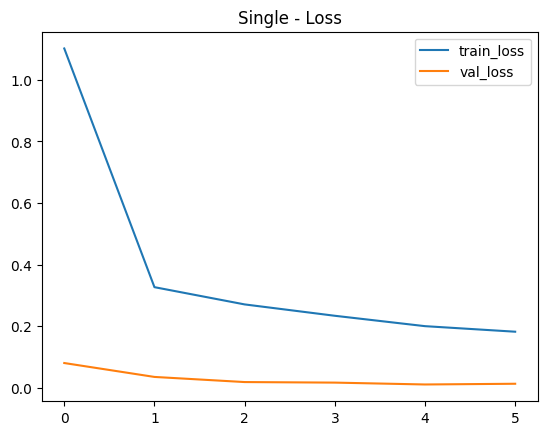

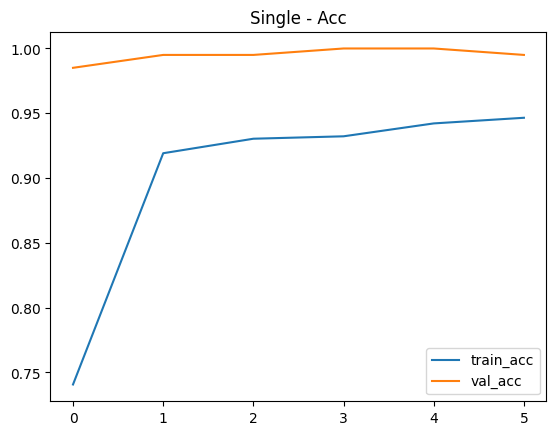

In [ ]:
def create_model(num_classes, pretrained=True):
    model = models.resnet18(pretrained=pretrained)
    in_feats = model.fc.in_features
    model.fc = nn.Linear(in_feats, num_classes)
    return model

model_single = create_model(num_classes).to(DEVICE)
criterion_ce = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_single.parameters(), lr=1e-4)

EPOCHS_SINGLE = 6
best_val_acc = 0.0
history_single = {'train_loss':[], 'val_loss':[], 'train_acc':[], 'val_acc':[]}

for epoch in range(EPOCHS_SINGLE):
    model_single.train()
    running_loss = 0.0
    running_corrects = 0
    total = 0
    for inputs, labels in tqdm(train_loader_single, desc=f'Train single epoch {epoch+1}/{EPOCHS_SINGLE}'):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model_single(inputs)
        loss = criterion_ce(outputs, labels)
        loss.backward()
        optimizer.step()
        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data).item()
        total += inputs.size(0)
    train_loss = running_loss / total
    train_acc = running_corrects / total

    model_single.eval()
    val_loss = 0.0
    val_corrects = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in val_loader_single:
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)
            outputs = model_single(inputs)
            loss = criterion_ce(outputs, labels)
            _, preds = torch.max(outputs, 1)
            val_loss += loss.item() * inputs.size(0)
            val_corrects += torch.sum(preds == labels.data).item()
            val_total += inputs.size(0)
    val_loss = val_loss / val_total
    val_acc = val_corrects / val_total

    history_single['train_loss'].append(train_loss)
    history_single['val_loss'].append(val_loss)
    history_single['train_acc'].append(train_acc)
    history_single['val_acc'].append(val_acc)

    print(f'Epoch {epoch+1} train_loss {train_loss:.4f} train_acc {train_acc:.4f} | val_loss {val_loss:.4f} val_acc {val_acc:.4f}')
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model_single.state_dict(), OUTPUT_DIR / 'best_single.pth')

plt.figure(); plt.plot(history_single['train_loss'], label='train_loss'); plt.plot(history_single['val_loss'], label='val_loss'); plt.legend(); plt.title('Single - Loss'); plt.savefig(OUTPUT_DIR/'single_loss.png')
plt.figure(); plt.plot(history_single['train_acc'], label='train_acc'); plt.plot(history_single['val_acc'], label='val_acc'); plt.legend(); plt.title('Single - Acc'); plt.savefig(OUTPUT_DIR/'single_acc.png')

model_single.load_state_dict(torch.load(OUTPUT_DIR/'best_single.pth', map_location=DEVICE))
model_single.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for inputs, labels in test_loader_single:
        inputs = inputs.to(DEVICE)
        outputs = model_single(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(preds.cpu().numpy())

acc = accuracy_score(y_true, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro', zero_division=0)
print('Single test acc:', acc)
print('Single macro precision/recall/f1:', prec, rec, f1)

## Célula 5: Geração de Pseudo-Labels (Estratégia Semi-Supervisionada)
Utilizo o modelo treinado na etapa anterior para classificar as imagens da pasta "Imagens_Varios_Alimentos" (que não tinham rótulo). Com base nas probabilidades preditas, gero um arquivo CSV com Pseudo-Labels, assumindo como verdadeiros os alimentos identificados com maior confiança.

In [ ]:
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from PIL import Image

TRAIN_DIR = Path("Imagens_um_Alimento")
VAL_DIR = Path("Imagens_um_Alimento")
VARIOS_DIR = Path("Imagens_Varios_Alimentos")

varios_files = sorted([p.name for p in VARIOS_DIR.iterdir() 
                       if p.suffix.lower() in ['.jpg','.jpeg','.png']])
print("Total imagens vários:", len(varios_files))

train_dataset = datasets.DatasetFolder(
    root=TRAIN_DIR,
    loader=lambda x: Image.open(x).convert("RGB"),
    extensions=("png", "jpeg", "jpg"),
    transform=train_transform_single,
)

val_dataset = datasets.DatasetFolder(
    root=VAL_DIR,
    loader=lambda x: Image.open(x).convert("RGB"),
    extensions=("png", "jpeg", "jpg"),
    transform=val_transform_single,
)

class VariosDataset(Dataset):
    def __init__(self, file_list, root, transform=None):
        self.files = file_list
        self.root = Path(root)
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        fp = self.root / self.files[idx]
        img = Image.open(fp).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, self.files[idx]


varios_dataset = VariosDataset(varios_files, VARIOS_DIR, transform=val_transform_single)

varios_loader = DataLoader(
    varios_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=0
)

def predict_single_probs(model, loader, device):
    model.eval()
    all_probs = []
    all_files = []
    softmax = nn.Softmax(dim=1)

    with torch.no_grad():
        for inputs, files in tqdm(loader, desc="Predicting varios"):
            inputs = inputs.to(device)
            outputs = model(inputs)
            probs = softmax(outputs).cpu().numpy()
            all_probs.append(probs)
            all_files.extend(files)

    all_probs = np.vstack(all_probs)
    return all_files, all_probs

files_varios, probs_varios = predict_single_probs(model_single, varios_loader, DEVICE)

pseudo_labels = []
for p in probs_varios:
    labels = []
    top_idx = np.argsort(p)[::-1]

    if p[top_idx[0]] >= 0.15:
        labels.append(class_names[top_idx[0]])

    if p[top_idx[1]] >= 0.10:
        labels.append(class_names[top_idx[1]])

    for i, prob in enumerate(p):
        if prob >= 0.30 and class_names[i] not in labels:
            labels.append(class_names[i])

    if len(labels) == 0:
        labels.append(class_names[top_idx[0]])

    pseudo_labels.append(labels)

df_pseudo = pd.DataFrame({"filename": files_varios, "labels": pseudo_labels})
OUTPUT_DIR.mkdir(exist_ok=True)
df_pseudo.to_csv(OUTPUT_DIR / "pseudo_labels_varios.csv", index=False)

print("Saved pseudo-labels to", OUTPUT_DIR / "pseudo_labels_varios.csv")
print(df_pseudo.head())

Total imagens vários: 289


Predicting varios: 100%|██████████| 10/10 [00:10<00:00,  1.04s/it]

Saved pseudo-labels to outputs_multilabel\pseudo_labels_varios.csv
                     filename                       labels
0  IMG_20140922_141541933.jpg  [StrogonoffCarne, Maionese]
1  IMG_20140922_141545285.jpg  [StrogonoffCarne, Maionese]
2  IMG_20140922_141548258.jpg  [StrogonoffCarne, Maionese]
3  IMG_20140922_141552615.jpg  [Maionese, StrogonoffCarne]
4  IMG_20140922_141555901.jpg  [Maionese, StrogonoffCarne]


## Célula 6: Unificação dos Datasets
Fusão dos dados: combino o dataset original (rótulos manuais/confiáveis) com o dataset de pratos mistos (pseudo-rótulos). Crio um DataFrame único e realizo uma nova divisão (Split) dos dados para preparar a etapa de treinamento final Multi-Label.

In [ ]:
single_records = []
for cls in class_names:
    cls_dir = SINGLE_DIR / cls
    for p in cls_dir.iterdir():
        if p.suffix.lower() in ['.jpg','.jpeg','.png']:
            single_records.append({'filename': os.path.relpath(p, start='.'), 'labels':[cls]})

varios_records = []
for _, row in df_pseudo.iterrows():
    varios_records.append({'filename': os.path.join('Imagens_Varios_Alimentos', row['filename']), 'labels': row['labels']})

all_records = single_records + varios_records
df_all = pd.DataFrame(all_records)
print('Total records multi-label:', len(df_all))

df_all = df_all.sample(frac=1, random_state=SEED).reset_index(drop=True)

train_df, temp_df = train_test_split(df_all, test_size=0.2, random_state=SEED)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=SEED)

print('Multi-label splits:', len(train_df), len(val_df), len(test_df))

Total records multi-label: 2300
Multi-label splits: 1840 230 230


## Célula 7: DataLoaders Finais
Instanciação dos DataLoaders para o dataset unificado. Converto as imagens para Tensores e aplico a normalização padrão da ImageNet (média e desvio padrão), deixando os dados prontos para alimentar a rede neural em batches.

In [ ]:
train_transform_tensor = transforms.Compose([
    transforms.ConvertImageDtype(torch.float32),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

val_transform_tensor = transforms.Compose([
    transforms.ConvertImageDtype(torch.float32),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

ml_train = MultiLabelFolder(train_df, root_dir='.', transform=train_transform_tensor, class_to_idx=class_to_idx)
ml_val   = MultiLabelFolder(val_df,   root_dir='.', transform=val_transform_tensor,   class_to_idx=class_to_idx)
ml_test  = MultiLabelFolder(test_df,  root_dir='.', transform=val_transform_tensor,   class_to_idx=class_to_idx)

batch_size = 32

train_loader_ml = DataLoader(ml_train, batch_size=batch_size, shuffle=True,  num_workers=0)
val_loader_ml   = DataLoader(ml_val,   batch_size=batch_size, shuffle=False, num_workers=0)
test_loader_ml  = DataLoader(ml_test,  batch_size=batch_size, shuffle=False, num_workers=0)

print("Loaders multi-label prontos!")

Loaders multi-label prontos!


## Célula 8: Treinamento Multi-Label (Fine-Tuning)
Treinamento do modelo final. Aqui troco a função de perda para BCEWithLogitsLoss, que é a padrão para classificação multirrótulo (trata cada classe como uma classificação binária independente). O modelo treina por 8 épocas, salvando os pesos que obtiverem o melhor F1-Score na validação.

In [ ]:
model_ml = create_model(num_classes).to(DEVICE)
criterion_bce = nn.BCEWithLogitsLoss()
optimizer_ml = optim.Adam(model_ml.parameters(), lr=1e-4)

EPOCHS_ML = 8
best_val_f1 = 0.0
history_ml = {'train_loss':[], 'val_loss':[], 'val_f1':[]}

for epoch in range(EPOCHS_ML):
    model_ml.train()
    running_loss = 0.0
    total = 0
    for inputs, labels in tqdm(train_loader_ml, desc=f'Train ML epoch {epoch+1}/{EPOCHS_ML}'):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer_ml.zero_grad()
        outputs = model_ml(inputs)
        loss = criterion_bce(outputs, labels)
        loss.backward()
        optimizer_ml.step()
        running_loss += loss.item() * inputs.size(0)
        total += inputs.size(0)
    train_loss = running_loss / total

    model_ml.eval()
    val_loss = 0.0
    all_targets = []
    all_preds = []
    with torch.no_grad():
        for inputs, labels in val_loader_ml:
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)
            outputs = model_ml(inputs)
            loss = criterion_bce(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            probs = torch.sigmoid(outputs).cpu().numpy()
            all_targets.append(labels.cpu().numpy())
            all_preds.append(probs)
    val_loss = val_loss / len(val_loader_ml.dataset)
    all_targets = np.vstack(all_targets)
    all_preds = np.vstack(all_preds)
    pred_bin = (all_preds >= 0.5).astype(int)
    prec, rec, f1, _ = precision_recall_fscore_support(all_targets, pred_bin, average='micro', zero_division=0)
    val_f1 = f1
    history_ml['train_loss'].append(train_loss)
    history_ml['val_loss'].append(val_loss)
    history_ml['val_f1'].append(val_f1)

    print(f'Epoch {epoch+1} train_loss {train_loss:.4f} val_loss {val_loss:.4f} val_micro_f1 {val_f1:.4f}')
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model_ml.state_dict(), OUTPUT_DIR/'best_ml.pth')

plt.figure(); plt.plot(history_ml['train_loss'], label='train_loss'); plt.plot(history_ml['val_loss'], label='val_loss'); plt.legend(); plt.title('ML Loss'); plt.savefig(OUTPUT_DIR/'ml_loss.png')
plt.figure(); plt.plot(history_ml['val_f1'], label='val_micro_f1'); plt.legend(); plt.title('ML Val F1'); plt.savefig(OUTPUT_DIR/'ml_f1.png')

## Célula 9: Avaliação Quantitativa (Teste)
Carrego o melhor modelo salvo (best_ml.pth) e rodo no conjunto de teste. Gero as métricas solicitadas no trabalho (Micro/Macro F1-Score e Hamming Loss) usando um limiar padrão de 0.5. Também salvo um arquivo JSON com todas as predições para análise qualitativa posterior.

In [ ]:
model_ml.load_state_dict(torch.load(OUTPUT_DIR/'best_ml.pth', map_location=DEVICE))
model_ml.eval()
all_targets = []
all_probs = []
filenames_test = []
with torch.no_grad():
    for inputs, labels in tqdm(test_loader_ml, desc='Test ML'):
        inputs = inputs.to(DEVICE)
        outputs = model_ml(inputs)
        probs = torch.sigmoid(outputs).cpu().numpy()
        all_probs.append(probs)
        all_targets.append(labels.numpy())

all_probs = np.vstack(all_probs)
all_targets = np.vstack(all_targets)

preds_bin = (all_probs >= 0.5).astype(int)

micro_prec, micro_rec, micro_f1, _ = precision_recall_fscore_support(all_targets, preds_bin, average='micro', zero_division=0)
macro_prec, macro_rec, macro_f1, _ = precision_recall_fscore_support(all_targets, preds_bin, average='macro', zero_division=0)
ham_loss = hamming_loss(all_targets, preds_bin)

print('Multi-label test results (threshold=0.5):')
print('Micro P/R/F1:', micro_prec, micro_rec, micro_f1)
print('Macro P/R/F1:', macro_prec, macro_rec, macro_f1)
print('Hamming loss:', ham_loss)

per_class = precision_recall_fscore_support(all_targets, preds_bin, average=None, zero_division=0)
per_class_df = pd.DataFrame({'class': class_names, 'precision': per_class[0], 'recall': per_class[1], 'f1': per_class[2]})
per_class_df.to_csv(OUTPUT_DIR/'per_class_ml.csv', index=False)
print('Per-class metrics saved to', OUTPUT_DIR/'per_class_ml.csv')

ml_cm = multilabel_confusion_matrix(all_targets, preds_bin)
for i, cm in enumerate(ml_cm):
    np.savetxt(OUTPUT_DIR/f'cm_class_{class_names[i]}.csv', cm, delimiter=',', fmt='%d')

filenames_test = test_df['filename'].values
preds_list = [class_names[i] for i in range(len(class_names))]

out_rows = []
for i, fname in enumerate(filenames_test):
    probs = all_probs[i]
    pred_labels = [class_names[j] for j in range(len(class_names)) if preds_bin[i, j] == 1]
    true_labels = [class_names[j] for j in range(len(class_names)) if all_targets[i, j] == 1]
    out_rows.append({'filename': fname, 'true': true_labels, 'pred': pred_labels, 'probs': probs.tolist()})

pd.DataFrame(out_rows).to_json(OUTPUT_DIR/'test_predictions.json', orient='records')
print('Saved test predictions to', OUTPUT_DIR/'test_predictions.json')

## Célula 10: Otimização de Limiares (Threshold Tuning)
Para refinar o resultado, executo um algoritmo de busca no conjunto de validação. Em vez de usar 50% de certeza para tudo, encontro o Threshold ideal para cada alimento (ex: ser mais rigoroso com Arroz e mais flexível com Alface) para maximizar o F1-Score final.

c:\Users\gabri\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\gabri\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Train ML epoch 1/8: 100%|██████████| 58/58 [00:51<00:00,  1.12it/s]


Epoch 1 train_loss 0.3128 val_loss 0.1219 val_micro_f1 0.9372


Train ML epoch 2/8: 100%|██████████| 58/58 [00:52<00:00,  1.10it/s]


Epoch 2 train_loss 0.0724 val_loss 0.0578 val_micro_f1 0.9631


Train ML epoch 3/8: 100%|██████████| 58/58 [00:51<00:00,  1.12it/s]


Epoch 3 train_loss 0.0384 val_loss 0.0364 val_micro_f1 0.9654


Train ML epoch 4/8: 100%|██████████| 58/58 [00:51<00:00,  1.12it/s]


Epoch 4 train_loss 0.0258 val_loss 0.0339 val_micro_f1 0.9574


Train ML epoch 5/8: 100%|██████████| 58/58 [00:52<00:00,  1.12it/s]


Epoch 5 train_loss 0.0189 val_loss 0.0246 val_micro_f1 0.9657


Train ML epoch 6/8: 100%|██████████| 58/58 [00:52<00:00,  1.10it/s]


Epoch 6 train_loss 0.0158 val_loss 0.0225 val_micro_f1 0.9735


Train ML epoch 7/8: 100%|██████████| 58/58 [00:52<00:00,  1.11it/s]


Epoch 7 train_loss 0.0126 val_loss 0.0212 val_micro_f1 0.9717


Train ML epoch 8/8: 100%|██████████| 58/58 [00:52<00:00,  1.11it/s]


Epoch 8 train_loss 0.0108 val_loss 0.0222 val_micro_f1 0.9595


Test ML: 100%|██████████| 8/8 [00:06<00:00,  1.22it/s]


Multi-label test results (threshold=0.5):
Micro P/R/F1: 0.9799196787148594 0.9682539682539683 0.9740518962075848
Macro P/R/F1: 0.9789790372670808 0.9694110576923076 0.9737951607835387
Hamming loss: 0.003532608695652174
Per-class metrics saved to outputs_multilabel\per_class_ml.csv
Saved test predictions to outputs_multilabel\test_predictions.json
Best thresholds per class: {'Alface': np.float64(0.1), 'Almondega': np.float64(0.1), 'Arroz': np.float64(0.1), 'BatataFrita': np.float64(0.2), 'Beterraba': np.float64(0.2), 'BifeBovinoChapa': np.float64(0.30000000000000004), 'CarneBovinaPanela': np.float64(0.5), 'Cenoura': np.float64(0.1), 'FeijaoCarioca': np.float64(0.25), 'Macarrao': np.float64(0.1), 'Maionese': np.float64(0.2), 'PeitoFrango': np.float64(0.15000000000000002), 'PureBatata': np.float64(0.1), 'StrogonoffCarne': np.float64(0.25), 'StrogonoffFrango': np.float64(0.25), 'Tomate': np.float64(0.30000000000000004)}
Test micro f1 with tuned thresholds: 0.9631067961165048
Pipeline compl

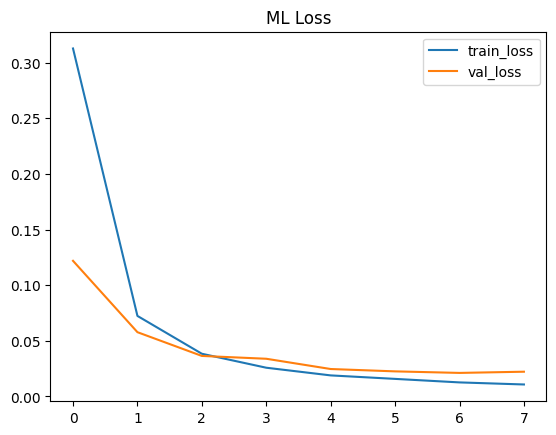

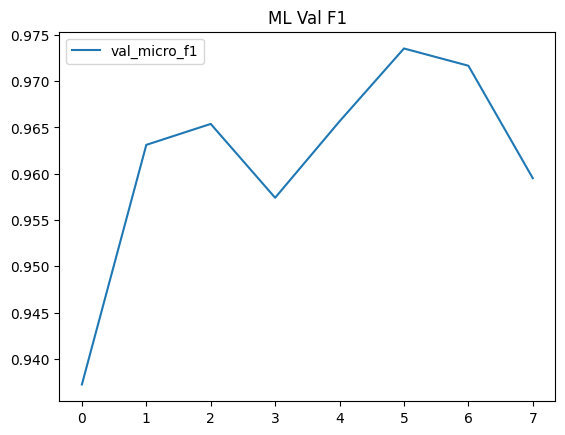

In [ ]:
val_probs = None
val_targets = None
with torch.no_grad():
    all_p = []
    all_t = []
    for inputs, labels in val_loader_ml:
        inputs = inputs.to(DEVICE)
        out = model_ml(inputs)
        all_p.append(torch.sigmoid(out).cpu().numpy())
        all_t.append(labels.numpy())
    val_probs = np.vstack(all_p)
    val_targets = np.vstack(all_t)

best_thresholds = np.full(num_classes, 0.5)
for c in range(num_classes):
    best_f1 = 0.0
    best_t = 0.5
    for t in np.linspace(0.1,0.9,17):
        predc = (val_probs[:,c] >= t).astype(int)
        prec, rec, f1, _ = precision_recall_fscore_support(val_targets[:,c], predc, average='binary', zero_division=0)
        if f1 > best_f1:
            best_f1 = f1
            best_t = t
    best_thresholds[c] = best_t

print('Best thresholds per class:', dict(zip(class_names, best_thresholds)))
np.savetxt(OUTPUT_DIR/'best_thresholds.txt', best_thresholds)

preds_best = (all_probs >= best_thresholds.reshape(1,-1)).astype(int)
prec_b, rec_b, f1_b, _ = precision_recall_fscore_support(all_targets, preds_best, average='micro', zero_division=0)
print('Test micro f1 with tuned thresholds:', f1_b)

torch.save({'single_model': OUTPUT_DIR/'best_single.pth', 'ml_model': OUTPUT_DIR/'best_ml.pth'}, OUTPUT_DIR/'models_info.pth')

print('Pipeline completo. Verifique pasta', OUTPUT_DIR, 'para arquivos gerados.')